<a href="https://colab.research.google.com/github/mspsullivan/DataCleaningProject/blob/master/TutorialExtractionAvetisyan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Follow the tutorial page written here: https://kedion.medium.com/ml-security-with-the-adversarial-robustness-toolbox-d173b24e8c1a

In [ ]:
pip install adversarial-robustness-toolbox

In [ ]:
pip install tensorflow

In [3]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

In [4]:
# Loading the data
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="mnist")


In [5]:
# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

In [ ]:
# Instantiating the model
model = create_model()

# Training the model
model.fit(
    x=train_images, 
    y=train_labels, 
    epochs=10,
    batch_size=256)

In [7]:
# Creating a classifier by wrapping our TF model in ART's KerasClassifier class
classifier = KerasClassifier(
    model=model, 
    clip_values=(min, max)
    )

In [8]:
# Defining an attack using the fast gradient method
attack_fgsm = FastGradientMethod(
    estimator=classifier, 
    eps=0.3
    )

In [9]:
# Generating adversarial images from test images
test_images_adv = attack_fgsm.generate(x=test_images)

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


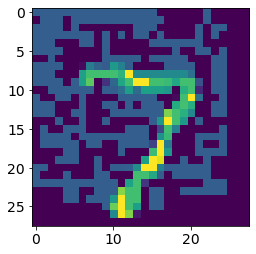

In [10]:
# Viewing an adversarial image
#X = np.expand_dims(test_images_adv[0], axis=1)  # or axis=1
if test_images_adv[0].shape[2] == 1:
    X = test_images_adv[0][:, :, 0]
plt.imshow(X)


In [ ]:
# Evaluating the model on clean images
score_clean = model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Evaluating the model on adversarial images
score_adv = model.evaluate(
    x=test_images_adv, 
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

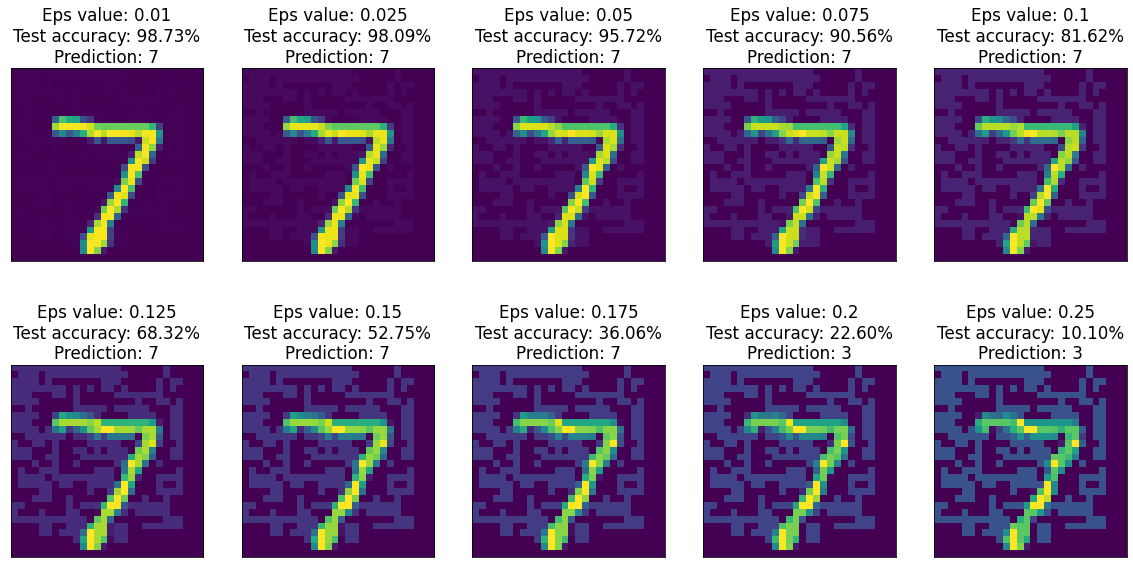

In [12]:
# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object for the current value of eps    
        attack_fgsm = FastGradientMethod(
            estimator=classifier, 
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)

        # Showing the first adversarial image
        if test_images_adv[0].shape[2] == 1:
          X = test_images_adv[0][:, :, 0]
        axes[i, j].imshow(X)

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv, 
            y=test_labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()

#Part 2 model extraction

In [22]:
# Creating the "neural net thief" object
# that will steal the original classifier
from art.attacks.extraction import CopycatCNN

# stash the classifier from above
classifier_original = classifier

# Loading the data
(train_images_stolen, train_labels_stolen), (test_images_stolen, test_labels_stolen), min, max = load_dataset(name="mnist")

copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=len(train_images_stolen),
    use_probability = False,
    classifier = classifier
    )

#nb_stolen=len(train_images_stolen) essentially determines how many samples ART will use to train the stolen model.

In [25]:
# Creating a reference model for theft
model_stolen = KerasClassifier(
    model=create_model(), 
    clip_values=(min, max)
    )
stolen_classifier = model_stolen

#Evaluate performance

In [26]:
#Testing the performance of the original classifier
score_original = classifier_original._model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Testing the performance of the stolen classifier
score_stolen = stolen_classifier._model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} " 
      f"vs stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} " 
      f"vs stolen test accuracy: {score_stolen[1]:.2f}")

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Original test loss: 0.04 vs stolen test loss: 2.31
Original test accuracy: 0.99 vs stolen test accuracy: 0.06


#Original test loss: 0.04 vs stolen test loss: 0.08Original test accuracy: 0.99 vs stolen test accuracy: 0.98

In [27]:
# Defining subsets to try
data_subsets_to_try = [2500, 5000, 7500, 10000]

# Initializing a dict to store scores
scores = {}

# Iterating over each data subset
for data_subset in data_subsets_to_try:
    # Creating a reference model for theft
    model_stolen = KerasClassifier(
        model=create_model(), 
        clip_values=(0, 1)
        )

    # Creating the "neural net thief" object
    # to train with the current subset size
    copycat_cnn = CopycatCNN(
        batch_size_fit=256,
        batch_size_query=256,
        nb_epochs=20,
        nb_stolen=data_subset,
        classifier=classifier_original
    )

    # Extracting a thieved classifier,
    # using a subset of the stolen data
    stolen_classifier = copycat_cnn.extract(
        x=train_images_stolen[:data_subset], 
        y=train_labels_stolen[:data_subset], 
        thieved_classifier=model_stolen
        )

    # Calculating test metrics for the current stolen model
    scores[data_subset] = stolen_classifier._model.evaluate(
        x=test_images,
        y=test_labels
    )   

Train on 2500 samples
Epoch 1/20
2500/2500 [==============================] - 2s 803us/sample - loss: 2.1623 - accuracy: 0.4220
Epoch 2/20
2500/2500 [==============================] - 2s 742us/sample - loss: 1.6006 - accuracy: 0.7344
Epoch 3/20
2500/2500 [==============================] - 2s 788us/sample - loss: 0.8558 - accuracy: 0.8176
Epoch 4/20
2500/2500 [==============================] - 2s 747us/sample - loss: 0.5056 - accuracy: 0.8524
Epoch 5/20
2500/2500 [==============================] - 2s 744us/sample - loss: 0.3899 - accuracy: 0.8816
Epoch 6/20
2500/2500 [==============================] - 2s 728us/sample - loss: 0.3105 - accuracy: 0.9084
Epoch 7/20
2500/2500 [==============================] - 2s 720us/sample - loss: 0.2631 - accuracy: 0.9280
Epoch 8/20
2500/2500 [==============================] - 2s 721us/sample - loss: 0.2291 - accuracy: 0.9372
Epoch 9/20
2500/2500 [==============================] - 2s 742us/sample - loss: 0.1996 - accuracy: 0.9452
Epoch 10/20
2500/2500 [=

Train on 5000 samples
Epoch 1/20
5000/5000 [==============================] - 4s 754us/sample - loss: 1.7500 - accuracy: 0.5484
Epoch 2/20
5000/5000 [==============================] - 4s 779us/sample - loss: 0.6084 - accuracy: 0.8318
Epoch 3/20
5000/5000 [==============================] - 4s 776us/sample - loss: 0.3457 - accuracy: 0.8986
Epoch 4/20
5000/5000 [==============================] - 4s 739us/sample - loss: 0.2616 - accuracy: 0.9252
Epoch 5/20
5000/5000 [==============================] - 4s 825us/sample - loss: 0.2074 - accuracy: 0.9384
Epoch 6/20
5000/5000 [==============================] - 5s 992us/sample - loss: 0.1755 - accuracy: 0.9486
Epoch 7/20
5000/5000 [==============================] - 4s 738us/sample - loss: 0.1450 - accuracy: 0.9574
Epoch 8/20
5000/5000 [==============================] - 4s 886us/sample - loss: 0.1219 - accuracy: 0.9638
Epoch 9/20
5000/5000 [==============================] - 4s 809us/sample - loss: 0.0998 - accuracy: 0.9700
Epoch 10/20
5000/5000 [=

Train on 7500 samples
Epoch 1/20
7500/7500 [==============================] - 6s 769us/sample - loss: 1.5066 - accuracy: 0.6023
Epoch 2/20
7500/7500 [==============================] - 6s 755us/sample - loss: 0.4101 - accuracy: 0.8757
Epoch 3/20
7500/7500 [==============================] - 6s 764us/sample - loss: 0.2596 - accuracy: 0.9271
Epoch 4/20
7500/7500 [==============================] - 6s 790us/sample - loss: 0.1990 - accuracy: 0.9448
Epoch 5/20
7500/7500 [==============================] - 6s 769us/sample - loss: 0.1581 - accuracy: 0.9531
Epoch 6/20
7500/7500 [==============================] - 6s 745us/sample - loss: 0.1322 - accuracy: 0.9615
Epoch 7/20
7500/7500 [==============================] - 6s 745us/sample - loss: 0.1128 - accuracy: 0.9672
Epoch 8/20
7500/7500 [==============================] - 6s 742us/sample - loss: 0.0958 - accuracy: 0.9739
Epoch 9/20
7500/7500 [==============================] - 6s 751us/sample - loss: 0.0850 - accuracy: 0.9768
Epoch 10/20
7500/7500 [=

Train on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 9s 896us/sample - loss: 1.2496 - accuracy: 0.6764
Epoch 2/20
10000/10000 [==============================] - 7s 744us/sample - loss: 0.3483 - accuracy: 0.8978
Epoch 3/20
10000/10000 [==============================] - 8s 752us/sample - loss: 0.2469 - accuracy: 0.9273
Epoch 4/20
10000/10000 [==============================] - 8s 755us/sample - loss: 0.1887 - accuracy: 0.9458
Epoch 5/20
10000/10000 [==============================] - 7s 721us/sample - loss: 0.1483 - accuracy: 0.9557
Epoch 6/20
10000/10000 [==============================] - 8s 753us/sample - loss: 0.1166 - accuracy: 0.9641
Epoch 7/20
10000/10000 [==============================] - 7s 740us/sample - loss: 0.0977 - accuracy: 0.9716
Epoch 8/20
10000/10000 [==============================] - 9s 895us/sample - loss: 0.0839 - accuracy: 0.9757
Epoch 9/20
10000/10000 [==============================] - 7s 718us/sample - loss: 0.0742 - accuracy: 0.9770
Epoch

#Visualize test losses

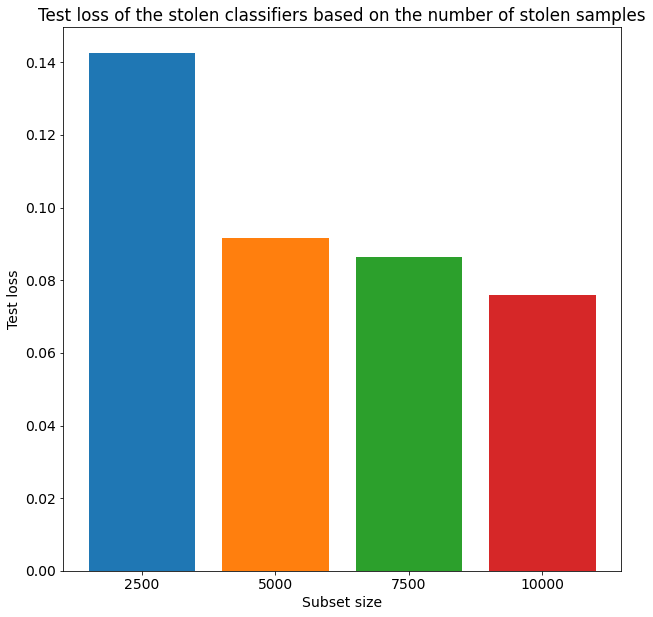

In [28]:
# Converting the dict values to a Python list
score_values = list(scores.values())

# Creating a matplotlib figure
fig = plt.figure(figsize=(10, 10))

# Iterating over our data subsets,
# plotting the test loss for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]), 
        height=score_values[i][0]
        )

# Setting a title for the figure and showing it
plt.title(label="Test loss of the stolen classifiers based on the number of stolen samples")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test loss")
plt.show()

#Visualize accuracy

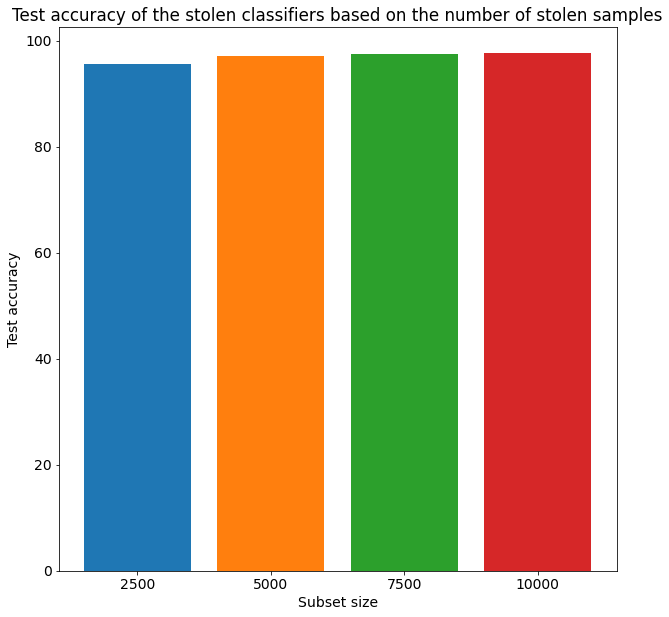

In [29]:
# Creating a matplotlib figure
fig = plt.figure(figsize=(10, 10))

# Iterating over our data subsets,
# plotting the test accuracy for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]), 
        height=score_values[i][1] * 100
        )

# Setting a title for the figure and showing it
plt.title(label="Test accuracy of the stolen classifiers based on the number of stolen samples")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test accuracy")
plt.show()